In [1]:
#Author     : Fan Li
#Update Date: 2022.09.20
#Version    : 2.0

#Intrusion Detection System Using Machine Learning (Random Forest)

#Original Data (cic ids 2017)

#hardware
#64vCPUs | 128GiB | c7.16xlarge.2

#System
#Ubuntu 20.04 server 64bit

In [2]:
#1. Loading Module
#basic
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import gc    #memory manage

import math
import numpy as np
import pandas as pd

#draw figure
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing
from sklearn.preprocessing import LabelEncoder
from collections import Counter

#Feature Selection

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
#model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#metrics

from sklearn import model_selection,feature_selection,utils,ensemble,metrics

#time
from time import time
import datetime

In [30]:
#2. Reading Dataset
base_path="../../data/"
# Monday benign
f1_path=base_path+"Monday-WorkingHours.pcap_ISCX.csv"
f1=pd.read_csv(f1_path)
#Tuesday benign
f2_path=base_path+"Tuesday-WorkingHours.pcap_ISCX.csv"
f2=pd.read_csv(f2_path)
#Wed benign
f3_path=base_path+"Wednesday-workingHours.pcap_ISCX.csv"
f3=pd.read_csv(f3_path)
#Thur WebAttack
f4_path1=base_path+"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
f41=pd.read_csv(f4_path1)
f4_path2=base_path+"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f42=pd.read_csv(f4_path2)
#Fri Benign DDos PortScan
f5_path1=base_path+"Friday-WorkingHours-Morning.pcap_ISCX.csv"
f51=pd.read_csv(f5_path1)

f5_path2=base_path+"Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
f52=pd.read_csv(f5_path2)

f5_path3=base_path+"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f53=pd.read_csv(f5_path3)

In [31]:
data=pd.concat((f1,f2,f3,f41,f42,f51,f52,f53))
data.reset_index(inplace=True,drop=True) # duplicate index exist, reset index
data.shape

(2830743, 79)

In [32]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [33]:
#3. Preprocessing
#3.1 remove useless data
#remove duplicate row
data=data.drop_duplicates()
#remove rows with null value and infinite value
data=data.replace(np.inf,np.nan)
data=data.dropna()

In [34]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
print(Counter(y))

Counter({'BENIGN': 2072476, 'DoS Hulk': 172846, 'DDoS': 128014, 'PortScan': 90694, 'DoS GoldenEye': 10286, 'FTP-Patator': 5931, 'DoS slowloris': 5385, 'DoS Slowhttptest': 5228, 'SSH-Patator': 3219, 'Bot': 1948, 'Web Attack � Brute Force': 1470, 'Web Attack � XSS': 652, 'Infiltration': 36, 'Web Attack � Sql Injection': 21, 'Heartbleed': 11})


In [35]:
#Label Encoding
le=LabelEncoder()
le=le.fit(y)
le.classes_
y=le.transform(y)
print(Counter(y))

Counter({0: 2072476, 4: 172846, 2: 128014, 10: 90694, 3: 10286, 7: 5931, 6: 5385, 5: 5228, 11: 3219, 1: 1948, 12: 1470, 14: 652, 9: 36, 13: 21, 8: 11})


In [36]:
#Ram Clean
del data
gc.collect()

1962

In [28]:
#3.3 Scaler
mms=MinMaxScaler()
X=mms.fit_transform(X)

In [29]:
#X=VarianceThreshold().fit_transform(X)
#X.shape
rfc=RandomForestClassifier(bootstrap=True,random_state=123456,n_jobs=-1)

In [12]:
threshold=np.linspace(0,(rfc.fit(X,y).feature_importances_).max(),20)

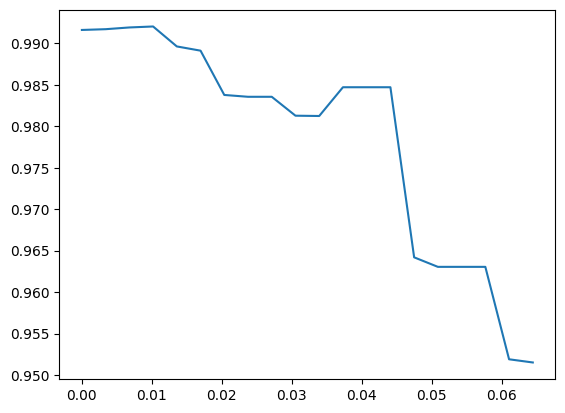

In [13]:
score=[]
for i in threshold:
    X_emb=SelectFromModel(rfc,threshold=i).fit_transform(X,y)
    sc=cross_val_score(rfc,X_emb,y,cv=5).mean()
    score.append(sc)
plt.plot(threshold,score)
plt.show()

In [17]:
score,threshold

([0.991601206124812,
  0.9916932718164851,
  0.9919022208892398,
  0.9920203050067613,
  0.9896153883886465,
  0.9891046243315571,
  0.9837668163886013,
  0.983545458549654,
  0.983545458549654,
  0.9812670328280539,
  0.9812306069032027,
  0.984696681721452,
  0.984696681721452,
  0.984696681721452,
  0.9641952584317085,
  0.963048040000635,
  0.963048040000635,
  0.963048040000635,
  0.9519072921842484,
  0.9515226178293744],
 array([0.        , 0.00339282, 0.00678564, 0.01017846, 0.01357128,
        0.0169641 , 0.02035692, 0.02374975, 0.02714257, 0.03053539,
        0.03392821, 0.03732103, 0.04071385, 0.04410667, 0.04749949,
        0.05089231, 0.05428513, 0.05767795, 0.06107077, 0.06446359]))

In [18]:
X_em=SelectFromModel(rfc,threshold=0.01017846).fit_transform(X,y)

In [19]:
X_em.shape

(2498217, 36)

In [20]:
cross_val_score(rfc,X_em,y,cv=5).mean()

0.9920203050067613

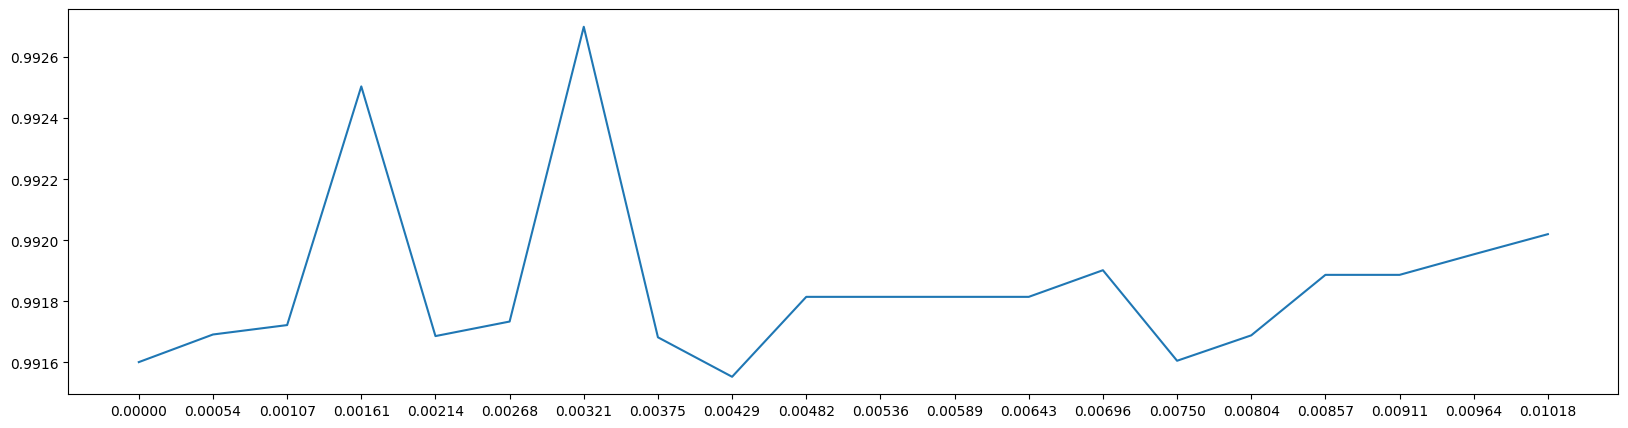

In [37]:
score2=[]
for i in np.linspace(0,0.01017846,20):
    X_embedded=SelectFromModel(rfc,threshold=i).fit_transform(X,y)
    sc=cross_val_score(rfc,X_embedded,y,cv=5).mean()
    score2.append(sc)
plt.figure(figsize=[20,5])
plt.plot(np.linspace(0,0.01017846,20),score2)
plt.xticks(np.linspace(0,0.01017846,20))
plt.show()

In [43]:
for i in np.linspace(0,0.01017846,20):
    print(i)

0.0
0.0005357084210526316
0.0010714168421052633
0.0016071252631578948
0.0021428336842105266
0.0026785421052631583
0.0032142505263157897
0.0037499589473684214
0.004285667368421053
0.0048213757894736845
0.005357084210526317
0.005892792631578948
0.006428501052631579
0.0069642094736842115
0.007499917894736843
0.008035626315789475
0.008571334736842106
0.009107043157894738
0.009642751578947369
0.01017846


In [45]:
X_em=SelectFromModel(rfc,threshold=0.0032142505263157897).fit_transform(X,y)

In [46]:
#3.4 Splitting data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X_em,y,test_size=0.33,random_state=123456)

In [47]:
print(Counter(y_train))

Counter({0: 1388615, 4: 115556, 2: 85778, 10: 60860, 3: 6923, 7: 3977, 6: 3704, 5: 3506, 11: 2123, 1: 1293, 12: 987, 14: 436, 9: 20, 13: 17, 8: 10})


In [48]:
#4. Training
clf=RandomForestClassifier(bootstrap=True,random_state=12345,n_jobs=-1)

In [49]:
time1=time()
clf.fit(X_train,y_train)
print("Time of Training : {:.3f} s".format(time()-time1))

Time of Training : 79.822 s


In [50]:
y_pred_train=clf.predict(X_train) 
y_pred_test=clf.predict(X_test)

In [51]:
#5. Result 
#5.1 Original Data
print("==Train==")
result=metrics.confusion_matrix(y_train,y_pred_train)
report=metrics.classification_report(y_train,y_pred_train,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_train,y_pred_train))
print("Precison       = ",metrics.precision_score(y_train,y_pred_train,average='macro'))
print("Recall         = ",metrics.recall_score(y_train,y_pred_train,average='macro'))
print("F1_score       = ",metrics.f1_score(y_train,y_pred_train,average='macro'))

==Train==
[[1388363       0       1       0      28       0       0       0       0
        0     223       0       0       0       0]
 [      0    1293       0       0       0       0       0       0       0
        0       0       0       0       0       0]
 [      0       0   85778       0       0       0       0       0       0
        0       0       0       0       0       0]
 [      0       0       0    6923       0       0       0       0       0
        0       0       0       0       0       0]
 [     39       0       0       0  115517       0       0       0       0
        0       0       0       0       0       0]
 [      0       0       0       0       0    3506       0       0       0
        0       0       0       0       0       0]
 [      0       0       0       0       0       0    3704       0       0
        0       0       0       0       0       0]
 [      0       0       0       0       0       0       0    3977       0
        0       0       0       0       0

In [52]:
print("==Test==")
result=metrics.confusion_matrix(y_test,y_pred_test)
report=metrics.classification_report(y_test,y_pred_test,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_test,y_pred_test))
print("Precison       = ",metrics.precision_score(y_test,y_pred_test,average='macro'))
print("Recall         = ",metrics.recall_score(y_test,y_pred_test,average='macro'))
print("F1_score       = ",metrics.f1_score(y_test,y_pred_test,average='macro'))

==Test==
[[683347     75      3      3     77     11      2      0      0      1
     342      0      0      0      0]
 [   154    501      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [    18      0  42217      0      1      0      0      0      0      0
       0      0      0      0      0]
 [    13      0      0   3342      4      4      0      0      0      0
       0      0      0      0      0]
 [   153      0      0      7  57124      0      0      0      0      0
       6      0      0      0      0]
 [     3      0      0      1      0   1714      4      0      0      0
       0      0      0      0      0]
 [     8      0      0      0      0      3   1670      0      0      0
       0      0      0      0      0]
 [     2      0      0      0      0      0      0   1951      0      0
       0      0      0      0      1]
 [     0      0      0      0      0      0      0      0      1      0
       0      0      0      0      0]
 

### Random Forest With Original Data
Accuracy Score =  0.8339877858220367
Precison       =  0.9334938648682805
Recall         =  0.8339877858220367
F1_score       =  0.8596253090330319

### chi2
k=40
Accuracy Score =  0.8571673854340448
Precison       =  0.9312930927300515
Recall         =  0.8571673854340448
F1_score       =  0.8844409291224661

### chi2
k=38
Accuracy Score =  0.8721818711264772
Precison       =  0.933530732209585
Recall         =  0.8721818711264772
F1_score       =  0.8942931895421073

###Select from model  threshold=0.01017846
Accuracy Score =  0.8522627306949482
Precison       =  0.9273986418654943
Recall         =  0.8522627306949482
F1_score       =  0.8732862194641502